Lab 2: Text Classification
=============

In this problem set, you will build a system for automatically classifying song lyrics comments by era. You will:

- Do some basic text processing, tokenizing your input and converting it into a bag-of-words representation
- Build a machine learning classifier based on the generative model, using Naive Bayes
- Evaluate your classifiers and examine what they have learned
- Build a logistic regression classifier (discriminative model) using PyTorch

Total Points: 100 points + 20 bonus points

# 0. Setup

In order to develop this assignment, you will need [python 3.6](https://www.python.org/downloads/) and the following libraries. Most if not all of these are part of [anaconda](https://www.continuum.io/downloads), so a good starting point would be to install that.

- [jupyter](http://jupyter.readthedocs.org/en/latest/install.html)
- numpy (This will come if you install scipy like above, but if not install separately)
- [matplotlib](http://matplotlib.org/users/installing.html)
- [nosetests](https://nose.readthedocs.org/en/latest/)
- [pandas](http://pandas.pydata.org/) Dataframes

Here is some help on installing packages in python: https://packaging.python.org/installing/. You can use ```pip --user``` to install locally without sudo.

## About this assignment

- This is a Jupyter notebook. You can execute cell blocks by pressing control-enter.
- Most of your coding will be in the python source files in the directory ```gtnlplib```. Some functions in these source files will remain empty, and we will not touch them. Do not worry about that, and do not assume you are doing something wrong.
- The directory ```tests``` contains unit tests that will be used to grade your assignment, using ```nosetests```. You should run them as you work on the assignment to see that you're on the right track. You are free to look at their source code, if that helps -- though most of the relevant code is also here in this notebook. Learn more about running unit tests at http://pythontesting.net/framework/nose/nose-introduction/
- You may want to add more tests, but that is completely optional. 
- **To submit this assignment, compress the whole directory using tar, and submit the tarball ```lab2-submission.tgz``` on Compass.**

In [1]:
import sys
from importlib import reload

In [2]:
print('My Python version')

print('python: {}'.format(sys.version))

My Python version
python: 3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [3]:
import nose

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
from torch import optim
from collections import Counter
%matplotlib inline

In [4]:
print('My library versions')

print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('scipy: {}'.format(sp.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('nose: {}'.format(nose.__version__))
print('torch: {}'.format(torch.__version__))

My library versions
pandas: 0.25.1
numpy: 1.17.2
scipy: 1.3.1
matplotlib: 3.1.1
nose: 1.3.7
torch: 1.3.1


To test whether your libraries are the right version, run:

`nosetests tests/test_environment.py`

In [5]:
# use ! to run shell commands in notebook
! nosetests tests/test_environment.py

.
----------------------------------------------------------------------
Ran 1 test in 0.000s

OK


# 1. Preprocessing

Total: 10 points

Read the data into a dataframe

In [6]:
df_train = pd.read_csv('lyrics-train.csv')

A dataframe is a structured representation of your data. You can preview a dataframe using `head()`

In [7]:
df_train.head()

,Era,Lyrics
0,pre-1980,come on come on let me show you where its at a...
1,1980s,welcome to the big time youre bound to be a s...
2,pre-1980,once i believed that when love came to me it ...
3,2000s,i took my love and i took it down climbed a m...
4,pre-1980,do do do do do do do do do do do do do do do ...


## Bags of words

Your first task is to convert the text to a bag-of-words representation. For this data, a lot of the preprocessing is already done: the text is lower-cased, and punctuation is removed. You need only create a `counter` for each instance.

- **Deliverable 1.1**: Complete the function `gtnlplib.preproc.bag_of_words`. (2.5 points)
- **Test**: `nose tests/test_preproc.py:test_d1_1_bow`

In [8]:
from gtnlplib import preproc

In [9]:
# run this block to update the notebook as you change the preproc library
reload(preproc);

In [10]:
y_tr,x_tr = preproc.read_data('lyrics-train.csv',preprocessor=preproc.bag_of_words)
y_dv,x_dv = preproc.read_data('lyrics-dev.csv',preprocessor=preproc.bag_of_words)

In [11]:
y_te,x_te = preproc.read_data('lyrics-test-hidden.csv',preprocessor=preproc.bag_of_words)

In [12]:
! nosetests tests/test_preproc.py:test_d1_1_bow

.
----------------------------------------------------------------------
Ran 1 test in 0.449s

OK


## Unseen words

One challenge for classification is that words will appear in the test data that do not appear in the training data. Compute the number of words that appear in `lyrics-dev.csv`, but not in `lyrics-train.csv`. To do this, implement the following deliverables:

- **Deliverable 1.2**: implement `gtnlplib.preproc.aggregate_counts`, a counter of all words in a list of bags-of-words.  (2.5 points)
- **Deliverable 1.3**: implement `gtnlplib.preproc.compute_oov`, returning a list of words that appear in one list of bags-of-words, but not another.  (2.5 points)
- **Tests**: `tests/test_preproc.py:test_d1_2_agg`, `tests/test_preproc.py:test_d1_3a_oov`

In [13]:
from collections import Counter

In [14]:
reload(preproc);

To write fast code, you can find bottlenecks using the %%timeit cell magic. 

In [15]:
%%timeit
preproc.aggregate_counts(x_tr)

118 ms ± 3.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
! nosetests tests/test_preproc.py:test_d1_2_agg

.
----------------------------------------------------------------------
Ran 1 test in 0.390s

OK


In [17]:
counts_dv = preproc.aggregate_counts(x_dv)

You can see the most common items in a counter by calling `counts.most_common()`:

In [18]:
counts_dv.most_common(5)

[('you', 5542), ('i', 5535), ('the', 5061), ('to', 3203), ('and', 2953)]

In [19]:
counts_tr = preproc.aggregate_counts(x_tr)

In [20]:
len(preproc.compute_oov(counts_dv,counts_tr))

2677

In [21]:
len(preproc.compute_oov(counts_tr,counts_dv))

30459

In [22]:
preproc.oov_rate(counts_dv,counts_tr)

0.297246280257606

In [23]:
!nosetests tests/test_preproc.py:test_d1_3a_oov

.
----------------------------------------------------------------------
Ran 1 test in 0.416s

OK


30% of the words in the dev set do not appear in the training set.

## Pruning the vocabulary

Let's prune the vocabulary to include only words that appear at least ten times in the training data.

- **Deliverable 1.4:** Implement `preproc.prune_vocabulary` (2.5 points)
- **Test**: `tests/test_preproc.py:test_d1_4_prune`

In [24]:
reload(preproc);

In [25]:
x_tr_pruned, vocab = preproc.prune_vocabulary(counts_tr,x_tr,10)
x_dv_pruned, _ = preproc.prune_vocabulary(counts_tr,x_dv,10)
x_te_pruned, _ = preproc.prune_vocabulary(counts_tr,x_te,10)

In [26]:
len(vocab)

4875

In [27]:
i = 94
print(len(x_dv[i]),len(x_dv_pruned[i]))
print(sum(x_dv[i].values()),sum(x_dv_pruned[i].values()))

88 79
187 176


In [28]:
! nosetests tests/test_preproc.py:test_d1_4_prune

.
----------------------------------------------------------------------
Ran 1 test in 0.578s

OK


# 2. Linear classification

Now you'll implement the linear classification rule, $\hat{y} = \text{argmax}_y \theta^{\top} f(x,y)$.

You will use these functions in all classifiers in this assignment.

Total: 20 points.

In [29]:
from gtnlplib import clf_base
reload(clf_base)

from gtnlplib import constants
reload(constants);

The feature function vector $f(x,y)$ can be viewed as a dict, in which the values are counts, and the keys are tuples $(y,x_j)$, where $y$ is a label and $x_j$ is a base feature.

- **Deliverable 2.1**: Implement the function ```make_feature_vector``` in ```clf_base.py```. (10 points)
- **Test**: `tests/test_classifier.py:test_d2_1_featvec`

Note that you must also include the offset feature, ```gtnlplib.constants.OFFSET```.

Desired output is shown below:

In [30]:
fv = clf_base.make_feature_vector({'test':1,'case':2},'1980s')

In [31]:
print(fv)

defaultdict(<class 'float'>, {('1980s', 'test'): 1, ('1980s', 'case'): 2, ('1980s', '**OFFSET**'): 1})


In [32]:
! nosetests tests/test_classifier.py:test_d2_1_featvec

.
----------------------------------------------------------------------
Ran 1 test in 0.516s

OK


Let's compute the entire set of labels.

In [33]:
labels = set(y_tr) #figure out all possible labels
print(labels)

{'1990s', '2000s', '1980s', 'pre-1980'}


Now implement the prediction rule, $\hat{y} = \text{argmax}_y \theta^{\top} f(x,y)$.

- **Deliverable 2.2**: Implement the function ```predict``` in ```clf_base.py```. (10 points)
- **Test**: `tests/test_classifier.py:test_d2_2_predict`

The output should be:

- A predicted label
- The scores of all labels

This function will be called **a lot**, so try to make it fast. You don't need to do anything crazy, but avoid making your code do silly extra work. It's worth trying out a couple different versions using %%timeit.

You can test this function using these simple hand-crafted weights.

In [34]:
from collections import defaultdict

In [35]:
# weight vectors must be defaultdicts
theta_hand = defaultdict(float,
                         {('2000s','money'):0.1,
                          ('2000s','name'):0.2,
                          ('1980s','tonight'):0.1,
                          ('2000s','man'):0.1,
                          ('1990s','fly'):0.1,
                          ('pre-1980',constants.OFFSET):0.1
                         })

In [36]:
clf_base.predict(x_tr_pruned[0],theta_hand,labels)

('2000s',
 {'1990s': 0.0, '2000s': 1.3000000000000003, '1980s': 0.0, 'pre-1980': 0.1})

In [37]:
! nosetests tests/test_classifier.py:test_d2_2_predict

.
----------------------------------------------------------------------
Ran 1 test in 0.568s

OK


Now let's see how good these weights are, by evaluating on the dev set.

In [38]:
from gtnlplib import evaluation
reload(evaluation);

In [39]:
# this applies your predict function to all the instances in ```x_dv```
y_hat = clf_base.predict_all(x_dv_pruned,theta_hand,labels)
print(evaluation.acc(y_hat,y_dv))

0.3422222222222222


# 3. Naive Bayes

You'll now implement a Naive Bayes classifier, as described in chapter 1 of the notes.

Total: 30 points

In [40]:
from gtnlplib import naive_bayes
reload(naive_bayes);

- **Deliverable 3.1**: (warmup) implement ```get_corpus_counts``` in ```naive_bayes.py```. (7.5 points)
- **Test**: `tests/test_classifier.py:test_d3_1_corpus_counts`

This function should compute the word counts for a given label.

In [41]:
eighties_counts = naive_bayes.get_corpus_counts(x_tr_pruned,y_tr,"1980s");
print(eighties_counts['today'])
print(eighties_counts['yesterday'])

50
14


In [42]:
!nosetests tests/test_classifier.py:test_d3_1_corpus_counts

.
----------------------------------------------------------------------
Ran 1 test in 1.037s

OK


- **Deliverable 3.2**: Implement ```estimate_pxy``` in ```naive_bayes.py```. (7.5 points)
- **Test**: `tests/test_classifier.py:test_d3_2_pxy`

This function should compute the *smoothed* multinomial distribution $\log P(x \mid y)$ for a given label $y$.

Hint: note that this function takes the vocabulary as an argument. You have to assign a probability even for words that do not appear in documents with label $y$, if they are in the vocabulary.

You can use ```get_corpus_counts``` in this function if you want to, but you don't have to.

In [43]:
log_pxy = naive_bayes.estimate_pxy(x_tr_pruned,y_tr,"1980s",0.1,vocab)

Probabilities must sum to one! (or very close)

In [44]:
print(type(log_pxy))

<class 'collections.defaultdict'>


In [45]:
sum(np.exp(list(log_pxy.values())))

0.9999999999999793

In [46]:
! nosetests tests/test_classifier.py:test_d3_2_pxy

.
----------------------------------------------------------------------
Ran 1 test in 0.651s

OK


Let's look at the log-probabilities of the words from the hand-tuned weights

In [47]:
print({word:log_pxy[word] for (_,word),weight in theta_hand.items() if weight>0})

{'money': -7.689562807416732, 'name': -7.568324713816848, 'tonight': -6.216637557007501, 'man': -6.631876946457839, 'fly': -8.636944126360918, '**OFFSET**': 0.0}


In [48]:
log_pxy_more_smooth = naive_bayes.estimate_pxy(x_tr_pruned,y_tr,"1980s",10,vocab)

In [49]:
print({word:log_pxy_more_smooth[word] for (_,word),weight in theta_hand.items() if weight>0})

{'money': -7.801363512554179, 'name': -7.691160372420565, 'tonight': -6.4054072405225515, 'man': -6.808471387093178, 'fly': -8.60745110429472, '**OFFSET**': 0.0}


- **Deliverable 3.3**: Now you are ready to implement ```estimate_nb``` in ```naive_bayes.py```. (7.5 points)
- **Test**: `tests/test_classifier.py:test_d3_3a_nb`



- The goal is that the score given by ```clf_base.predict``` is equal to the joint probability $P(x,y)$, as described in the notes.
- Don't forget the offset feature, whose weights should be set to the prior $\log P(y)$.
- The log-probabilities for the offset feature should not be smoothed.
- You can call the functions you have defined above, but you don't have to.

In [50]:
theta_nb = naive_bayes.estimate_nb(x_tr_pruned,y_tr,0.1)

In [51]:
clf_base.predict(x_tr_pruned[155],theta_nb,labels)

('2000s',
 {'1990s': -2125.1966084804503,
  '2000s': -2099.2474010561396,
  '1980s': -2153.0199277981355,
  'pre-1980': -2136.8348423968023})

In [52]:
y_hat = clf_base.predict_all(x_dv_pruned,theta_nb,labels)
print(evaluation.acc(y_hat,y_dv))

0.46444444444444444


In [53]:
! nosetests tests/test_classifier.py:test_d3_3a_nb

.
----------------------------------------------------------------------
Ran 1 test in 0.802s

OK


In [54]:
# this block shows how we write and read predictions for evaluation
evaluation.write_predictions(y_hat,'nb-dev.preds')
y_hat_dv = evaluation.read_predictions('nb-dev.preds')
evaluation.acc(y_hat_dv,y_dv)

0.46444444444444444

In [55]:
# execute this block to write predictions for the test set
y_hat = clf_base.predict_all(x_te_pruned,theta_nb,labels)
evaluation.write_predictions(y_hat,'nb-test.preds')

- **Deliverable 3.4**: Write a function in ```naive_bayes.py``` called ```find_best_smoother```, which finds the smoothing value that gives best performance on the dev data.  (7.5 points)
- **Test**: `tests/test_classifier.py:test_d3_4a_nb_best`

Your function should be trying at least the following values in `vals` below.

Then, using this smoothing value, run your Naive Bayes classifier on the test set, and output the results.

In [56]:
vals = np.logspace(-3,2,11)
print(vals)

[1.00000000e-03 3.16227766e-03 1.00000000e-02 3.16227766e-02
 1.00000000e-01 3.16227766e-01 1.00000000e+00 3.16227766e+00
 1.00000000e+01 3.16227766e+01 1.00000000e+02]


In [57]:
best_smoother, scores = naive_bayes.find_best_smoother(x_tr_pruned,y_tr,x_dv_pruned,y_dv,vals)

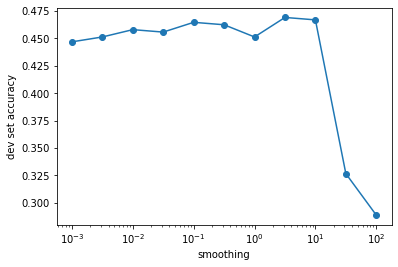

In [58]:
plt.semilogx(list(scores.keys()),list(scores.values()),'o-');
plt.xlabel('smoothing')
plt.ylabel('dev set accuracy');

**Reflect:**

- what might explain the dramatic drop in accuracy when the smoothing is increased from $10$ to $30$?
- before you check, predict whether the accuracy will continue to significantly drop if you further increase the smoothing to $10000$.

## We smooth to account for the absence of certain words in our training set. for example if the word lol appears 0 times we would say that it may not have occured in the training set but may occur in the test data so we smooth it  to say for example 0.0001% of the words is lol instead of 0%. If we increase smoothing we are saying that a word that doesnt appear in the training data may appear in the test data more times than we were saying it would with lesser smoothing. In other words, we observe lol 0 times and are now smoothing to say it accounts 0.001% of the words . A word that appears 0 times in the training data could never really appear significantly more number of times in the test data so our accuracy drops as we increase smoothing and estimate insignificant words to be way more significant than they actually are. 

In [59]:
theta_nb = naive_bayes.estimate_nb(x_tr_pruned,y_tr,best_smoother)
y_hat = clf_base.predict_all(x_te_pruned,theta_nb,labels)
evaluation.write_predictions(y_hat,'nb-best-test.preds')

In [60]:
! nosetests tests/test_classifier.py:test_d3_4a_nb_best

.
----------------------------------------------------------------------
Ran 1 test in 2.222s

OK


# 4. Logistic regression

Total: 30 points

You will implement logistic regression in PyTorch.

## 4.1 Converting data to numpy

Numpy is a package for numerical computing in python.

You will need to convert your bag-of-words list of counters to a numpy array. 

- **Deliverable 4.1**: Implement `preproc.py:make_numpy()` (6 points)
- **Test**: `test_pytorch/test_d5_1_numpy`
- **Hint**: one approach is to start with `numpy.zeros((height,width))`, and then fill in the cells by iterating through the bag-of-words list

In [61]:
X = np.zeros((4,2))
print(X)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [62]:
X[1,1] = -1
X[2,0] = 1.5
print(X)

[[ 0.   0. ]
 [ 0.  -1. ]
 [ 1.5  0. ]
 [ 0.   0. ]]


In [63]:
reload(preproc);

In [64]:
X_tr = preproc.make_numpy(x_tr_pruned,vocab)
X_dv = preproc.make_numpy(x_dv_pruned,vocab)
X_te = preproc.make_numpy(x_te_pruned,vocab)

In [65]:
label_set = sorted(list(set(y_tr)))
print(label_set)

['1980s', '1990s', '2000s', 'pre-1980']


In [66]:
!nosetests tests/test_pytorch.py:test_d5_1_numpy

.
----------------------------------------------------------------------
Ran 1 test in 10.066s

OK


In [67]:
Y_tr = np.array([label_set.index(y_i) for y_i in y_tr])
Y_dv = np.array([label_set.index(y_i) for y_i in y_dv])

In [68]:
len(set(Y_tr))

4

## 4.2 Building a logistic regression model

- **Deliverable 4.2**: Complete `logreg.build_linear` (6 points)
- **Test**: `tests/test_pytorch.py:test_d5_2_logreg`

In [69]:
from gtnlplib import logreg
reload(logreg);

In [70]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [71]:
torch.manual_seed(765);

In [72]:
X_tr_var = Variable(torch.from_numpy(X_tr.astype(np.float32)))
X_dv_var = Variable(torch.from_numpy(X_dv.astype(np.float32)))
X_te_var = Variable(torch.from_numpy(X_te.astype(np.float32)))

It's always a good idea to check the dimensions of your data first.

In [73]:
print(X_tr_var.size())
print(X_dv_var.size())

torch.Size([4000, 4875])
torch.Size([450, 4875])


In [74]:
model = logreg.build_linear(X_tr,Y_tr)

In [75]:
scores = model.forward(X_dv_var)
print(scores)

tensor([[-0.7673, -0.7583, -0.3767,  0.0325],
        [ 0.1110, -0.3801, -0.3979,  0.1642],
        [-1.8015, -0.5595, -3.5092,  0.9633],
        ...,
        [-0.3965,  0.0962, -0.4972, -0.1959],
        [-0.1721, -0.5167, -0.2574,  0.1571],
        [-0.3643,  0.0312, -0.4181,  0.4564]], grad_fn=<AddmmBackward>)


In [76]:
!nosetests tests/test_pytorch.py:test_d5_2_logreg

.
----------------------------------------------------------------------
Ran 1 test in 9.180s

OK


## 4.3 Adding a log-softmax layer

We're done it for you in PyTorch. Write your own log-softmax function in numpy and verify the results.

- **Deliverable 4.3**: Complete `logreg.log_softmax` (6 points)
- **Test**: `tests/test_pytorch.py:test_d5_3_log_softmax`

In [77]:
model.add_module('softmax',torch.nn.LogSoftmax(dim=1))

In [78]:
model.forward(X_dv_var)[:3]

tensor([[-1.7426, -1.7336, -1.3520, -0.9427],
        [-1.1841, -1.6752, -1.6930, -1.1309],
        [-3.0214, -1.7793, -4.7291, -0.2566]], grad_fn=<SliceBackward>)

In [79]:
model.forward(X_dv_var)[:3].exp()

tensor([[0.1751, 0.1767, 0.2587, 0.3896],
        [0.3060, 0.1873, 0.1840, 0.3227],
        [0.0487, 0.1688, 0.0088, 0.7737]], grad_fn=<ExpBackward>)

Notice that each row sums up to one.

In [80]:
model.forward(X_dv_var)[:3].exp().sum(dim=1)

tensor([1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)

In [81]:
reload(logreg);

In [82]:
logreg.log_softmax(scores[:3].data.numpy()) 

array([[-1.7426362 , -1.7335784 , -1.3519608 , -0.9427422 ],
       [-1.1840885 , -1.675237  , -1.692963  , -1.1309158 ],
       [-3.0213726 , -1.7793286 , -4.7291145 , -0.25659704]],
      dtype=float32)

In [83]:
!nosetests tests/test_pytorch.py:test_d5_3_log_softmax

.
----------------------------------------------------------------------
Ran 1 test in 8.461s

OK


These should be very close to the PyTorch results.

## 4.4 Negative Log-Likelihood Loss

A loss function tells you how well your model is doing. It produces gradients that allows the optimizer to tune the model weights. We've done the Pytorch call for you, try implementing this yourself in numpy!

- **Deliverable 4.4**: Complete `logreg.nll_loss` (6 points)
- **Test**: `tests/test_pytorch.py:test_d5_4_nll_loss`

In [84]:
loss = torch.nn.NLLLoss()

In [85]:
Y_tr_var = Variable(torch.from_numpy(Y_tr))
Y_dv_var = Variable(torch.from_numpy(Y_dv))

In [86]:
logP = model.forward(X_tr_var)
print(loss.forward(logP,Y_tr_var))

tensor(1.5013, grad_fn=<NllLossBackward>)


In [87]:
reload(logreg);

In [88]:
logreg.nll_loss(logP.data.numpy(), Y_tr)

1.5013313

In [89]:
! nosetests tests/test_pytorch.py:test_d5_4_nll_loss

.
----------------------------------------------------------------------
Ran 1 test in 8.875s

OK


Again, This should be very similar to the PyTorch result above.

## 4.5 Putting everything together

An optimizer can be used to actually learn the weights. We provide the complete code below that you can train on in `logreg.train_model`.

In [90]:
reload(logreg);

In [91]:
# build a new model with a fixed seed
torch.manual_seed(765)
model = logreg.build_linear(X_tr,Y_tr)
model.add_module('softmax',torch.nn.LogSoftmax(dim=1))

In [92]:
model_trained, losses, accuracies = logreg.train_model(loss,model,
                                                       X_tr_var,
                                                       Y_tr_var,
                                                       X_dv_var=X_dv_var,
                                                       Y_dv_var = Y_dv_var,
                                                       num_its=100,
                                                       optim_args={'lr':0.02})

Epoch 1: Dev Accuracy: 0.2822222222222222
Epoch 11: Dev Accuracy: 0.29555555555555557
Epoch 21: Dev Accuracy: 0.29555555555555557
Epoch 31: Dev Accuracy: 0.31333333333333335
Epoch 41: Dev Accuracy: 0.31777777777777777
Epoch 51: Dev Accuracy: 0.35777777777777775
Epoch 61: Dev Accuracy: 0.41555555555555557
Epoch 71: Dev Accuracy: 0.35555555555555557
Epoch 81: Dev Accuracy: 0.35333333333333333
Epoch 91: Dev Accuracy: 0.3333333333333333


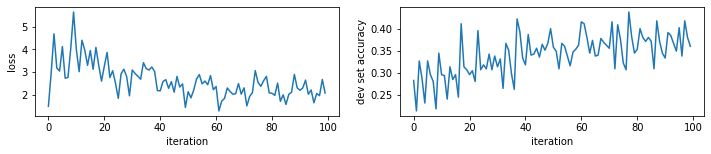

In [93]:
logreg.plot_results(losses,accuracies)

**Deliverable 4.5**
The noisy progress of the loss and dev set accuracy suggests that something is wrong with our hyperparameters. Tune the inputs to `train_model` until you can get to a dev set accuracy of at least 0.5. (6 points)

In [94]:
# build a new model with a fixed seed
torch.manual_seed(765)
model = logreg.build_linear(X_tr,Y_tr)
model.add_module('softmax',torch.nn.LogSoftmax(dim=1))

In [95]:
model_trained, losses, accuracies = logreg.train_model(loss,model,
                                                       X_tr_var,
                                                       Y_tr_var,
                                                       X_dv_var=X_dv_var,
                                                       Y_dv_var = Y_dv_var,
                                                       num_its=100,
                                                       optim_args={'lr':0.02})

Epoch 1: Dev Accuracy: 0.2822222222222222
Epoch 11: Dev Accuracy: 0.29555555555555557
Epoch 21: Dev Accuracy: 0.29555555555555557
Epoch 31: Dev Accuracy: 0.31333333333333335
Epoch 41: Dev Accuracy: 0.31777777777777777
Epoch 51: Dev Accuracy: 0.35777777777777775
Epoch 61: Dev Accuracy: 0.41555555555555557
Epoch 71: Dev Accuracy: 0.35555555555555557
Epoch 81: Dev Accuracy: 0.35333333333333333
Epoch 91: Dev Accuracy: 0.3333333333333333


In [96]:
_, Y_hat_dv = model_trained.forward(X_dv_var).max(dim=1)
np.save('logreg-es-dev.preds.npy', Y_hat_dv.data.numpy())

In [97]:
acc = evaluation.acc(np.load('logreg-es-dev.preds.npy'),Y_dv_var.data.numpy())
print(acc)

0.43777777777777777


In [98]:
_, Y_hat_te = model.forward(X_te_var).max(dim=1)
np.save('logreg-es-test.preds.npy', Y_hat_te.data.numpy())

# 5. Feature analysis

Total: 10 points


## 5.1 Top Features for Logistic Regression

- **Deliverable 5.1**: Implement ```get_top_features_for_label_torch``` in ```features.py```. (10 points)
- **Test**: `tests/test_features.py:test_d6_2_topfeat_torch`

**Hint**: Extract linear layer weights from the PyTorch model.

In [99]:
from gtnlplib import features
reload(features);

Load a fixed model so we have reproducible results. Feel free to change it to your own model.

In [100]:
model_test = torch.load('tests/test_weights.torch')

/Users/ab/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/ab/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/ab/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.activation.LogSoftmax' has changed. you can retrieve the original source code by 

In [101]:
features.get_top_features_for_label_torch(model_test, vocab, label_set,'pre-1980',5)

['love', 'lovin', 'and', 'baby', 'on']

In [102]:
features.get_top_features_for_label_torch(model_test, vocab, label_set,'1990s',7)

['here', 'power', 'jam', 'saw', 'yeah', 'want', 'yall']

In [103]:
! nosetests tests/test_features.py:test_d6_2_topfeat_torch

/Users/ab/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/ab/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/ab/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.activation.LogSoftmax' has changed. you can retrieve the original source code by 

# 6. Precision, Recall, and F1 (Bonus question)

Besides accuracy, systems in natural language processing are evaluated using precision, recall, and F1. Such measures are essential when evaluating on an unbalanced dataset in terms of classes (labels). Write a function below that takes in a predicted labels 'Y_hat' and gold labels 'Y', and returns the precision, recall, and F1.

Total: 20 points

In [104]:
from sklearn import metrics

In [105]:
def get_PR(Y_hat, Y):
    scores=[]
    labels=['1990s']
    for label in labels:
        tp = sum((Y_hat == Y)) 
        fp = sum((Y_hat == Y)) 
        fn = sum((Y_hat != label) & (Y == label))

        recall = tp/float(tp + fn + 1e-10)
        precission = tp/float(tp + fp + 1e-10)
        f1 = 2 * recall * precission / (recall + precission + 1e-10)
        lol=[precission,recall,f1]
        scores.append(lol)
    return precision, recall, f1
def get_PRF(Y_hat, Y):
    return(metrics.classification_report(Y,Y_hat))

In [106]:
print(get_PRF(Y_hat_dv, Y_dv))
print(get_PR(Y_hat_dv, Y_dv))

/Users/ab/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.41      0.30      0.34       104
           1       0.00      0.00      0.00        95
           2       0.41      0.96      0.58       127
           3       0.57      0.35      0.44       124

    accuracy                           0.44       450
   macro avg       0.35      0.40      0.34       450
weighted avg       0.37      0.44      0.36       450



TypeError: eq() received an invalid combination of arguments - got (numpy.ndarray), but expected one of:
 * (Tensor other)
      didn't match because some of the arguments have invalid types: ([31;1mnumpy.ndarray[0m)
 * (Number other)
      didn't match because some of the arguments have invalid types: ([31;1mnumpy.ndarray[0m)
